# Loading libraries

In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from dask.distributed import Client, progress
import geopandas
from clef.code import *
import os

# Connecting to ACCESS-ESM 1.5 database

In [2]:
client = Client(n_workers = 12)
#Creating a session and connecting to database
db = connect()
s = Session()

# Find data
Using conservative temperature as an example

In [3]:
constraints = {'variable_id': 'bigthetao', 'model': 'ACCESS-ESM1-5', 'frequency': 'mon', 'experiment_id':'historical'}
df = search(s, project = 'CMIP6', latest = True, **constraints)

# Loading data

In [4]:
path = df['path'][0]
filename = sorted([f[0] for f in zip(df['filename'][0])])
filepath = [os.path.join(path, f) for f in filename]
sst = xr.open_dataset(filepath[-2], mask_and_scale = True)

#Extracting vertices
lat_vert = sst.vertices_latitude[:,0, :]

# #Choosing one timestep for surface temperature
sst = sst.bigthetao[0, 0]

In [5]:
lat_vert[:,]

<xarray.DataArray 'vertices_latitude' (j: 300, vertices: 4)>
array([[-78.      , -78.      , -77.753166, -77.753166],
       [-77.753166, -77.753166, -77.505707, -77.505707],
       [-77.505707, -77.505707, -77.256996, -77.256996],
       ...,
       [ 65.      ,  65.416962,  65.418266,  65.      ],
       [ 65.      ,  65.418266,  65.419052,  65.      ],
       [ 65.      ,  65.419052,  65.419312,  65.      ]])
Coordinates:
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
    i          int32 0
    latitude   (j) float64 ...
    longitude  (j) float64 ...
Dimensions without coordinates: vertices
Attributes:
    units:    degrees_north

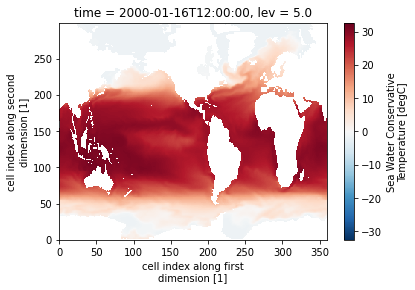

In [7]:
sst.plot()

# Changing longitude from 0-360 degrees to -180 to +180

In [29]:
#Making a deep copy of original longitude values in the array being corrected
lon = sst['longitude'][0].values

#Values changed from 0-360 to between -180 and +180.
lon[np.where(lon > 180)] = lon[np.where(lon >180)]-360

#Assigning corrected longitudes and latitude values to i and j, which are index based
sst.coords['i'] = lon
sst.coords['j'] = sst['latitude'][:,0].values
# sst.coords['j'] = lat_vert[:,-2].values

#Longitude values must be sorted from smallest to largest prior to plotting
sst = sst.sortby(sst.i)

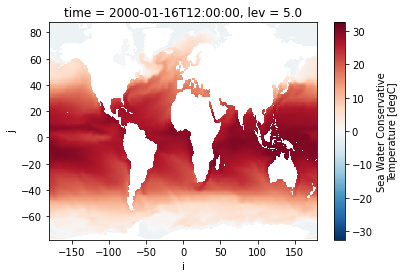

In [34]:
sst.plot()

In [35]:
sst['j'] = np.linspace(sst.j[0],sst.j[-1], sst.shape[0])

In [45]:
sst.j

<xarray.DataArray 'j' (j: 300)>
array([-77.876625, -77.323007, -76.769389, ...,  86.547893,  87.101511,
        87.655128])
Coordinates:
    time     datetime64[ns] 2000-01-16T12:00:00
    lev      float64 5.0
  * j        (j) float64 -77.88 -77.32 -76.77 -76.22 ... 85.99 86.55 87.1 87.66

In [46]:
sst.latitude[:,0]

<xarray.DataArray 'latitude' (j: 300)>
array([-77.876625, -77.629715, -77.381706, ...,  87.408272,  87.570129,
        87.655128])
Coordinates:
    time       datetime64[ns] 2000-01-16T12:00:00
    lev        float64 5.0
  * j          (j) float64 -77.88 -77.32 -76.77 -76.22 ... 86.55 87.1 87.66
    i          float64 -179.5
    latitude   (j) float64 -77.88 -77.63 -77.38 -77.13 ... 87.41 87.57 87.66
    longitude  (j) float64 ...
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    bounds:         vertices_latitude

# Select the Southern Ocean

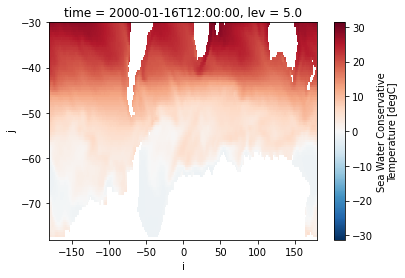

In [47]:
sst_SO = sst.sel(j = slice(-90, -30))
sst_SO.plot()

In [48]:
sst_SO.latitude[:,0]

<xarray.DataArray 'latitude' (j: 87)>
array([-77.876625, -77.629715, -77.381706, -77.132294, -76.880531, -76.626129,
       -76.368141, -76.106285, -75.839645, -75.567932, -75.29026 , -75.006363,
       -74.715355, -74.417   , -74.110443, -73.795479, -73.471268, -73.137634,
       -72.793785, -72.439552, -72.074196, -71.697586, -71.308998, -70.908363,
       -70.494987, -70.068848, -69.629288, -69.176323, -68.709351, -68.228439,
       -67.733017, -67.223198, -66.698479, -66.159004, -65.604324, -65.034637,
       -64.449539, -63.849281, -63.233509, -62.602528, -61.956032, -61.294376,
       -60.617313, -59.92524 , -59.21796 , -58.495926, -57.758991, -57.007656,
       -56.241821, -55.462036, -54.668247, -53.861053, -53.040443, -52.207062,
       -51.360947, -50.502777, -49.632637, -48.751244, -47.858719, -46.955818,
       -46.042698, -45.120152, -44.188366, -43.248169, -42.299767, -41.344021,
       -40.381168, -39.41209 , -38.437046, -37.456936, -36.472038, -35.483269,
       -34.490921, -33.49593 , -32.498589, -31.499844, -30.5     , -29.5     ,
       -28.500914, -27.508207, -26.52363 , -25.552488, -24.596292, -23.66004 ,
       -22.744862, -21.855303, -20.991982])
Coordinates:
    time       datetime64[ns] 2000-01-16T12:00:00
    lev        float64 5.0
  * j          (j) float64 -77.88 -77.32 -76.77 -76.22 ... -31.37 -30.82 -30.27
    i          float64 -179.5
    latitude   (j) float64 -77.88 -77.63 -77.38 -77.13 ... -22.74 -21.86 -20.99
    longitude  (j) float64 ...
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    bounds:         vertices_latitude

In [39]:
sst_SO.j

<xarray.DataArray 'j' (j: 87)>
array([-77.876625, -77.323007, -76.769389, -76.215771, -75.662153, -75.108536,
       -74.554918, -74.0013  , -73.447682, -72.894064, -72.340446, -71.786828,
       -71.23321 , -70.679592, -70.125974, -69.572356, -69.018739, -68.465121,
       -67.911503, -67.357885, -66.804267, -66.250649, -65.697031, -65.143413,
       -64.589795, -64.036177, -63.48256 , -62.928942, -62.375324, -61.821706,
       -61.268088, -60.71447 , -60.160852, -59.607234, -59.053616, -58.499998,
       -57.94638 , -57.392763, -56.839145, -56.285527, -55.731909, -55.178291,
       -54.624673, -54.071055, -53.517437, -52.963819, -52.410201, -51.856584,
       -51.302966, -50.749348, -50.19573 , -49.642112, -49.088494, -48.534876,
       -47.981258, -47.42764 , -46.874022, -46.320404, -45.766787, -45.213169,
       -44.659551, -44.105933, -43.552315, -42.998697, -42.445079, -41.891461,
       -41.337843, -40.784225, -40.230608, -39.67699 , -39.123372, -38.569754,
       -38.016136, -37.462518, -36.9089  , -36.355282, -35.801664, -35.248046,
       -34.694428, -34.140811, -33.587193, -33.033575, -32.479957, -31.926339,
       -31.372721, -30.819103, -30.265485])
Coordinates:
    time     datetime64[ns] 2000-01-16T12:00:00
    lev      float64 5.0
  * j        (j) float64 -77.88 -77.32 -76.77 -76.22 ... -31.37 -30.82 -30.27

In [49]:
# sst_SO = sst_SO.drop_vars(('latitude', 'longitude'))
sst_SO

<xarray.DataArray 'bigthetao' (j: 87, i: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [ 3.244226,  3.272089,  3.174737, ...,  2.784357,  2.931512,  3.104639],
       [ 2.567956,  2.685449,  2.677911, ...,  2.113763,  2.208887,  2.373895],
       ...,
       [26.544092, 26.54513 , 26.605036, ..., 26.594355, 26.581812, 26.589869],
       [27.282587, 27.26977 , 27.292109, ..., 27.295282, 27.28625 , 27.296656],
       [27.963984, 27.901087, 27.85409 , ..., 27.93661 , 28.005213, 28.008356]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2000-01-16T12:00:00
    lev        float64 5.0
  * j          (j) float64 -77.88 -77.32 -76.77 -76.22 ... -31.37 -30.82 -30.27
  * i          (i) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    latitude   (j, i) float64 -77.88 -77.88 -77.88 ... -20.99 -20.99 -20.99
    longitude  (j, i) float64 ...
Attributes:
    standard_name:   sea_water_conservative_temperature
    long_name:       Sea Water Conservative Temperature
    comment:         Sea water conservative temperature (this should be contr...
    units:           degC
    original_units:  K
    history:         2019-11-15T15:50:50Z altered by CMOR: Converted units fr...
    cell_methods:    area: mean where sea time: mean
    cell_measures:   area: areacello volume: volcello

In [100]:
sst_SO.j.values - sst_SO.latitude[:,0].values

array([ 0.        ,  0.30670781,  0.61231699,  0.91652235,  1.21837787,
        1.51759361,  1.81322354,  2.10498537,  2.39196356,  2.67386821,
        2.9498143 ,  3.21953481,  3.48214472,  3.73740752,  3.98446872,
        4.22312233,  4.45252912,  4.6725136 ,  4.88228232,  5.08166744,
        5.2699289 ,  5.446937  ,  5.61196695,  5.76495009,  5.90519214,
        6.03267022,  6.14672818,  6.24738131,  6.33402686,  6.40673351,
        6.46492905,  6.50872793,  6.53762659,  6.55177001,  6.55070804,
        6.53463906,  6.5031587 ,  6.45651873,  6.39436439,  6.31700085,
        6.22412293,  6.11608541,  5.99264033,  5.85418441,  5.70052311,
        5.53210656,  5.3487898 ,  5.15107256,  4.93885566,  4.71268841,
        4.4725174 ,  4.21894155,  3.95194941,  3.67218566,  3.37968845,
        3.0751368 ,  2.75861463,  2.4308391 ,  2.09193229,  1.7426495 ,
        1.38314713,  1.01421865,  0.63605097,  0.24947189, -0.14531261,
       -0.5474404 , -0.95667498, -1.37213514, -1.79356148, -2.22

# Load shapefile with boundaries to clip data array

In [101]:
# regions = geopandas.read_file(r'Indian.shp')
regions = geopandas.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO_shapes_withShelf/MEASO_shapes_withShelf.shp')
regions

,name,sector,zone,geometry
0,WPA-O,West Pacific,Antarctic Open,"POLYGON ((-125.00000 -65.20000, -125.00000 -65..."
1,WPA-N,West Pacific,Antarctic Shelf,"POLYGON ((-125.00000 -72.25443, -125.00000 -72..."
2,WPA-O,West Pacific,Antarctic Open,"POLYGON ((-180.00000 -72.36900, -180.00000 -72..."
3,WPS,West Pacific,Subantarctic,"POLYGON ((-125.00000 -56.80000, -125.00000 -57..."
4,WPN,West Pacific,Northern,"POLYGON ((-125.00000 -40.00000, -125.00000 -40..."
5,WPT,West Pacific,Temperate,"POLYGON ((-125.00000 -30.00000, -125.00000 -30..."
6,EPA-N,East Pacific,Antarctic Shelf,"POLYGON ((-125.00000 -75.00184, -125.00000 -75..."
7,EPA-O,East Pacific,Antarctic Open,"POLYGON ((-125.00000 -72.25443, -125.00000 -72..."
8,EPS,East Pacific,Subantarctic,"POLYGON ((-125.00000 -65.20000, -125.00000 -65..."
9,EPN,East Pacific,Northern,"POLYGON ((-125.00000 -56.80000, -125.00000 -56..."


# Assign data array the same coordinate reference system as the shapefile (WGS84)

In [102]:
sst_SO.rio.set_spatial_dims(x_dim = 'i', y_dim = 'j', inplace = True)
sst_SO.rio.write_crs(regions.crs, inplace = True)
sst_SO.rio.crs

CRS.from_epsg(4326)

# Checking shapefile and data array overlap

<AxesSubplot:title={'center':'time = 2000-01-16T12:00:00, lev = 5.0, spatial_...'}, xlabel='i', ylabel='j'>

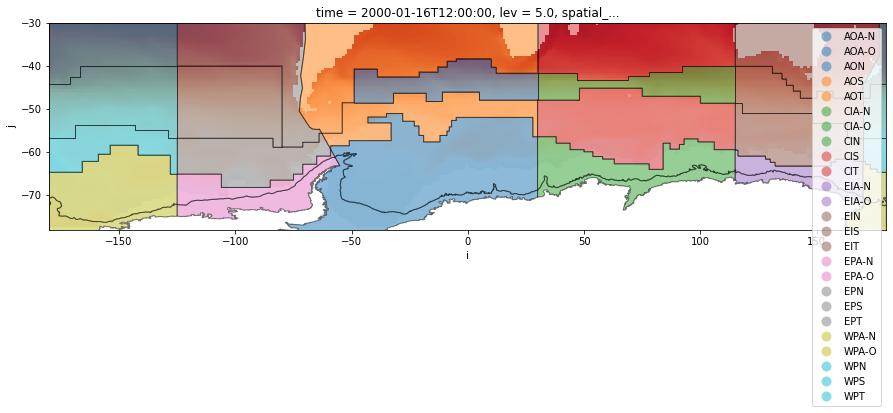

In [103]:
fig, ax = plt.subplots(figsize = (15, 20))
sst_SO.plot(ax = ax, add_colorbar = False)
regions.plot(ax = ax, edgecolor = 'black', column = 'name', alpha = 0.5, legend = True)

# Clipping data array
The region CIS will be used as an example for clipping.

<AxesSubplot:>

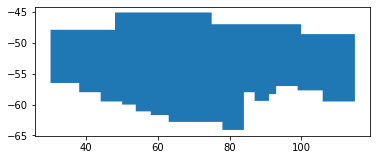

In [104]:
CIS = regions.query('name == "CIS"')
CIS.plot()

In [105]:
clipped = sst_SO.rio.clip(CIS.geometry, CIS.crs, drop = True, invert = False, all_touched = True)

#Also tried the following options, but the results were still not correct:
# clipped = sst_SO.rio.clip(CIS.geometry, sst_SO.crs, drop = True, invert = False, all_touched = True)
# clipped = sst_SO.rio.clip(CIS.geometry, sst_SO.crs, drop = True, invert = False, all_touched = False)
# clipped = sst_SO.rio.clip(CIS.geometry, CIS.crs, drop = True, invert = False, all_touched = False)

# Checking result

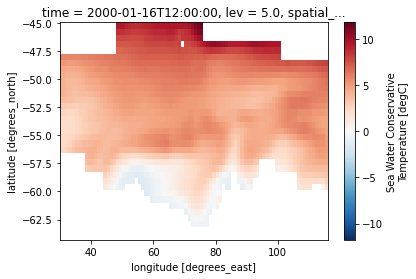

In [106]:
clipped.plot()

The result above is not correct, see the plot below overlaying the shapefile used for cutting the image

<AxesSubplot:title={'center':'time = 2000-01-16T12:00:00, lev = 5.0, spatial_...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

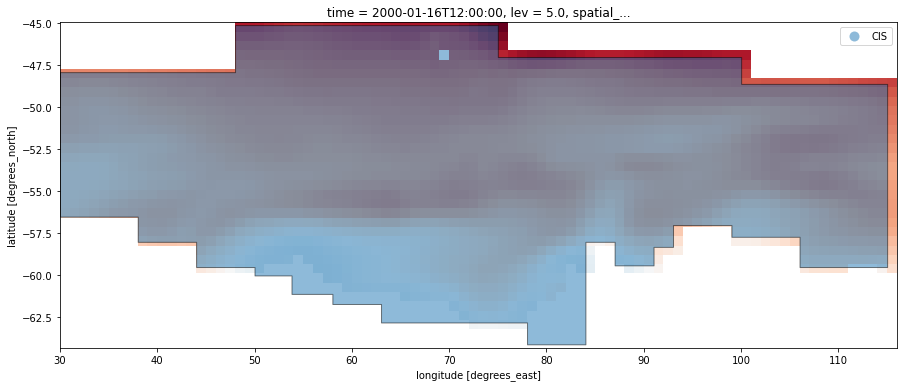

In [107]:
fig, ax = plt.subplots(figsize = (15, 20))
clipped.plot(ax = ax, add_colorbar = False)
CIS.plot(ax = ax, edgecolor = 'black', column = 'name', alpha = 0.5, legend = True)